# All plots and Data Analysis used in the Sim Storm Paper

Please make sure to run ProcessSamiData.py in utility_programs before running anything here

## Imports

In [1]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch

import sys
from mpl_toolkits.basemap import Basemap
import geopandas

from scipy.interpolate import LinearNDInterpolator, interp1d

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [2]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 10  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?


gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = [7,15,30,40] #set this to -1 if you want all columns
gitm_keo_lons = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 

num_pool_workers = 10 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')

sample_rate_min = 5 #min
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru



available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

In [3]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps/"

## Set up some useful functions:

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# for the maps!

In [5]:
# This will be used in plotting:
gitm_colnames_friendly = {'Rho': 'Total Neutral Density', '[O(!U3!NP)]': 'O(3P)', '[O!D2!N]': 'O2', '[N!D2!N]': 'N2', '[N(!U4!NS)]': 'N(4S)', '[NO]': 'NO', '[He]': 'He', '[N(!U2!ND)]': 'N(2D)', '[N(!U2!NP)]': 'N(2P)', '[H]': 'H', '[CO!D2!N]': 'CO2', '[O(!U1!ND)]': 'O(1D)', 'Temperature': 'Temperature', 'V!Dn!N(east)': 'Vn(east)', 'V!Dn!N(north)': 'Vn(north)', 'V!Dn!N(up)': 'Vn(up)', 'V!Dn!N(up,O(!U3!NP))': 'Vn(up,O(3P))', 'V!Dn!N(up,O!D2!N)': 'Vn(up,O2)', 'V!Dn!N(up,N!D2!N)': 'Vn(up,N2)', 'V!Dn!N(up,N(!U4!NS))': 'Vn(up,N(4S))', 'V!Dn!N(up,NO)': 'Vn(up,NO)', 'V!Dn!N(up,He)': 'Vn(up,He)', '[O_4SP_!U+!N]':'O(4Sp)+', '[NO!U+!N]': 'NO+', '[O!D2!U+!N]': 'O2+', '[N!D2!U+!N]': 'N2+', '[N!U+!N]': 'N+', '[O(!U2!ND)!U+!N]': 'O(2D)+', '[O(!U2!NP)!U+!N]': 'O(2P)+', '[H!U+!N]': 'H+', '[He!U+!N]': 'He+', '[e-]': 'e-', 'eTemperature': 'eTemperature', 'iTemperature': 'iTemperature', 'V!Di!N(east)': 'Vi(east)', 'V!Di!N(north)': 'Vi(north)', 'V!Di!N(up)': 'Vi(up)'}

In [6]:
def read_gitm_into_nparrays(flist):
    """reads a list of gitm filenames and returns a few numpy arrays.
    
    Parameters
    ----------
    flist: list
        List of gitm filenames to read in.
    
    Returns
    -------
    gitmtimes = list
        Datetimes corresponding to the times of the gitm files.
    gitmgrid = dict. 
        Holds the gitm grid for reference. lons/lats have been 
        changed to degrees from rads. Ghost cells removed.
        Keys are ['longitude', 'latitude', 'altitude']
        Index with gitmgrid[time][key][lon][lat][alt]
    gitmvars = list
        The gitm variables.
    gitmbins = numpy array. 
        All of the gitm data (except grid)
        index with gitmbins[time,varnumber,lat,lon,alt]
    
    """
    
    gitmtimes = []
    
    start = True
    for ifile, file_name in enumerate(tqdm(flist)):
        if start:
            f = read_routines.read_gitm_file(file_name)
            gitmgrid = {f['vars'][k].lower() : f[k][2:-2,2:-2,2:-2] for k in [0,1,2]}
            
            nlons, nlats, nalts = np.array(f[0].shape) - 4 # ghost cells
            gitmbins = np.zeros([len(flist), len(f['vars'])-3, nlons, nlats, nalts])
            gitmvars = [i for i in f['vars'][3:] if i in gitm_cols]
            start = False
        else:
            f = read_routines.read_gitm_file(file_name)
        
        gitmtimes.append(f['time']) # times
        
        for var in gitm_cols:
            num_v = f['vars'].index(var)
            gitmbins[ifile, num_v-3] = f[num_v][2:-2,2:-2,2:-2] # -3 is to adjust for grid, 2's are for ghost cells
            
    gitmgrid['latitude'] = np.rad2deg(gitmgrid['latitude'])
    gitmgrid['longitude'] = np.rad2deg(gitmgrid['longitude'])
        
    return gitmtimes, gitmgrid, gitmvars, gitmbins

In [7]:
def bandpass_filter(low_cut, high_cut, sample_rate_min):
    sampling_frequency = 1/(sample_rate_min*60)  # Sampling frequency (in Hz) #5 mins
    low_cutoff_frequency = 1/(low_cut*60)  # Low cutoff frequency (in Hz) #90 mins
    high_cutoff_frequency = 1/(high_cut*60)  # High cutoff frequency (in Hz) #50 mins

    coefficients = signal.butter(4, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', fs=sampling_frequency)
    bps = np.array(signal.filtfilt(coefficients[0], coefficients[1], noisy_signal))
    return bps

In [8]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

In [18]:
def make_fits(gitm_bins):
    """
    calculate bandpass filter for all data previously read in.
    
    inputs: nparray of gitmdata
    
    returns:
    fits: np array indexed at fits[time][col][ilon][ilat][ialt]
    gitmgrid[key][lon][lat][alt]
    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()

    filtered_arr = signal.sosfiltfilt(sos, gitm_bins, axis=0)
    return filtered_arr

In [11]:

def make_fits_df():
    """
    read in all data in df and then calculates bandpass filter for the data.
    
    inputs: none
    
    returns:
    fits: np array indexed at fits[ialt][ilat][ilon][col][time_array, len = len(times)]
    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()
    fits_full = np.zeros((len(alts),len(lats), len(lons), len(gitm_cols), len(times)))
    pbar = tqdm(desc = 'making fits..', total = len(alts) * len(lats) * len(lons))
    for nalt, ialt in enumerate(alts):

        df_sel = df[(df.alt == ialt)].reset_index(drop = True)
        for nlat, ilat in enumerate(lats):
            df_location = df_sel[(np.abs(df_sel.lat-ilat) < 0.2)].reset_index(drop = True)


            for nlon, ilon in enumerate(lons):
                df_location_sel = df_location[(np.abs(df_location.lon-ilon) < 0.2)].reset_index(drop = True)

                for ncol, icol in enumerate(gitm_cols):
                    bandpass_here = remove_background(df_location_sel[new_col], sos)

                    fits_full[nalt][-nlat][nlon][ncol] = bandpass_here
                pbar.update(1)

    return fits_full
            

In [12]:
def UT_from_Storm_onset(itime):
    """input the index of timelist
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(itime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

## Do GITM Plots First

In [14]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

### Read in all gitm files

In [15]:
times, gitm_grid, gitm_vars, gitm_bins = read_gitm_into_nparrays(gitm_files[plot_start_idx:plot_end_idx])

  0%|          | 0/168 [00:00<?, ?it/s]

In [16]:
lats, lons, alts  = np.unique(gitm_grid['latitude']), np.unique(gitm_grid['longitude']), np.unique(gitm_grid['altitude'])

### Calculate the fits for df

This is used in keos and the maps. Faster to just do it all now rather than have it done multiple times.

In [19]:
print('this will take a moment...')
fits_gitm = make_fits(gitm_bins)


In [20]:
fits_gitm.shape

(168, 37, 90, 180, 50)

### Keograms! of all columns!

In [13]:
times[0], times[0].astype(datetime.datetime), np.datetime64(dtime_storm_start)

(numpy.datetime64('2011-05-21T09:40:00.000000000'),
 1305970800000000000,
 numpy.datetime64('2011-05-21T13:40:00.000000'))

In [14]:
lats, lons, alts

(array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
        -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
        -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5,
        -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5,
        -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
        -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5,
        -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5,
        -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5,
        -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,
         -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
          0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
      

In [35]:
hrs_since_storm = np.array([(i - pd.Timestamp(dtime_storm_start)) / pd.Timedelta('1 hour') for i in times])

In [41]:
gitm_keo_lons

[-90, 2, 90, -178]

In [40]:
to_save = True
debug = True #this is only used if to_save is True and you only want one plot to appear here (for debugging)

# fits = {}

pbar = tqdm(desc = 'making keos..', total = len(gitm_keo_lons) * len(alts) * len(gitm_cols))
for ilon in gitm_keo_lons:
    # fits[ilon] = {}
    for ialt in gitm_k:

        plt.figure(figsize = (10,7))
        plt.imshow(bandpass, extent = [min(hrs_since_storm), max(hrs_since_storm), -keo_lat_lim, keo_lat_lim], aspect = 'auto', cmap = 'viridis')
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Hours since storm onset')
        plt.title('Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[icol].replace('(','[').replace(')',']'), ilon, round(ialt/1000,0)))
        plt.colorbar(label = 'Percent above bandpass filter')

        #plt.ylim(-65,65)

        if to_save:
            savedir = os.path.join(gitm_keo_save_path, str(ialt).split('.')[0][:3], 'lon'+str(ilon))
            if not debug:
                try:
                    plt.savefig(os.path.join(savedir, gitm_colnames_friendly[icol] + '.png'))
                except FileNotFoundError:
                    os.makedirs(os.path.join(savedir)) # get the directory of the plot, not the fname (colname_friendly)
                    plt.savefig(os.path.join(savedir, gitm_colnames_friendly[icol].replace('(','[').replace(')',']') + '.png'))
                plt.close()

            else:
                print(savedir, os.path.exists(savedir))
                plt.show()
                plt.close()
                break            
        else:
            plt.show()
            plt.close()
            break
        pbar.update(1)

        if not to_save or debug:
            break
    if not to_save or debug:
        break
            
pbar.close()

making keos..:   0%|          | 0/7400 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable int object

In [253]:
len(lats) * len(lons) * len(alts)

64800

In [252]:
df.keys()

Index(['alt', 'lat', 'lon', 'dtime', 'Rho', '[O(!U3!NP)]', '[O!D2!N]',
       '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]',
       '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)',
       'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))',
       'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))',
       'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]',
       '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]',
       '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature',
       'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'],
      dtype='object')

In [251]:
df

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature,iTemperature,V!Di!N(east),V!Di!N(north),V!Di!N(up)
0,109292.436412,-89.5,2.0,2011-05-21 09:40:00,9.781481e-08,2.912883e+17,3.066493e+17,1.571676e+18,1.701506e+12,3.335227e+12,...,7.238582e+04,3.562846e+04,1.0,3.531023e-15,5.288618e+10,204.811242,225.292367,13.805700,98.212810,-19.625231
1,109292.436412,-88.5,2.0,2011-05-21 09:40:00,9.792469e-08,2.900693e+17,3.078861e+17,1.573305e+18,1.790180e+12,3.762479e+12,...,8.995791e+04,4.443471e+04,1.0,3.526795e-15,5.931223e+10,207.468074,228.214882,20.206664,143.845500,-30.161132
2,109292.436412,-87.5,2.0,2011-05-21 09:40:00,9.795592e-08,2.885450e+17,3.088190e+17,1.573776e+18,1.876817e+12,4.227456e+12,...,1.093660e+05,5.415775e+04,1.0,3.524138e-15,6.584765e+10,208.239890,229.063879,22.276891,189.338618,-41.549893
3,109292.436412,-86.5,2.0,2011-05-21 09:40:00,9.788380e-08,2.866750e+17,3.092546e+17,1.572806e+18,1.971399e+12,4.759468e+12,...,1.305900e+05,6.480928e+04,1.0,3.522230e-15,7.239435e+10,209.577890,230.535679,19.895756,228.176690,-52.352644
4,109292.436412,-85.5,2.0,2011-05-21 09:40:00,9.769737e-08,2.849991e+17,3.092038e+17,1.569840e+18,2.110577e+12,5.435998e+12,...,1.750849e+05,8.701143e+04,1.0,3.521063e-15,8.380160e+10,211.990400,233.189440,16.225663,258.832633,-61.452501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10886395,513110.214043,85.5,-2.0,2011-05-21 23:35:00,9.463642e-13,2.259466e+13,3.217037e+11,6.750389e+12,3.027802e+11,1.066359e+10,...,1.598369e+09,1.755849e+07,1.0,1.475879e+06,1.000119e+11,2941.528836,2091.506190,-586.700825,-443.455198,-25.268824
10886396,513110.214043,86.5,-2.0,2011-05-21 23:35:00,9.780155e-13,2.346138e+13,3.304942e+11,6.912764e+12,3.154406e+11,1.123287e+10,...,1.614810e+09,1.817036e+07,1.0,1.464123e+06,1.010987e+11,2948.784720,2131.984397,-552.767409,-345.378338,0.923166
10886397,513110.214043,87.5,-2.0,2011-05-21 23:35:00,1.001021e-12,2.419722e+13,3.348940e+11,6.971572e+12,3.304064e+11,1.183729e+10,...,1.635891e+09,1.863221e+07,1.0,1.493224e+06,1.009208e+11,2954.958234,2162.889821,-476.670648,-248.921811,14.462110
10886398,513110.214043,88.5,-2.0,2011-05-21 23:35:00,1.005548e-12,2.451618e+13,3.323257e+11,6.881966e+12,3.413096e+11,1.228652e+10,...,1.654074e+09,1.879029e+07,1.0,1.544104e+06,9.968743e+10,2959.405348,2210.666078,-360.662760,-151.804014,12.140229


### Now map time

In [16]:
# go by col, get max & min, then loop thru dates
#  - should we get all the filtering done first? probably...
#    - yes, we did. fits[ilon][ialt][icol][ilat]

In [17]:
df_loc = df[(df.dtime == datetime.datetime(2011,5,21,14,55)) & (df.alt == alts[2])]

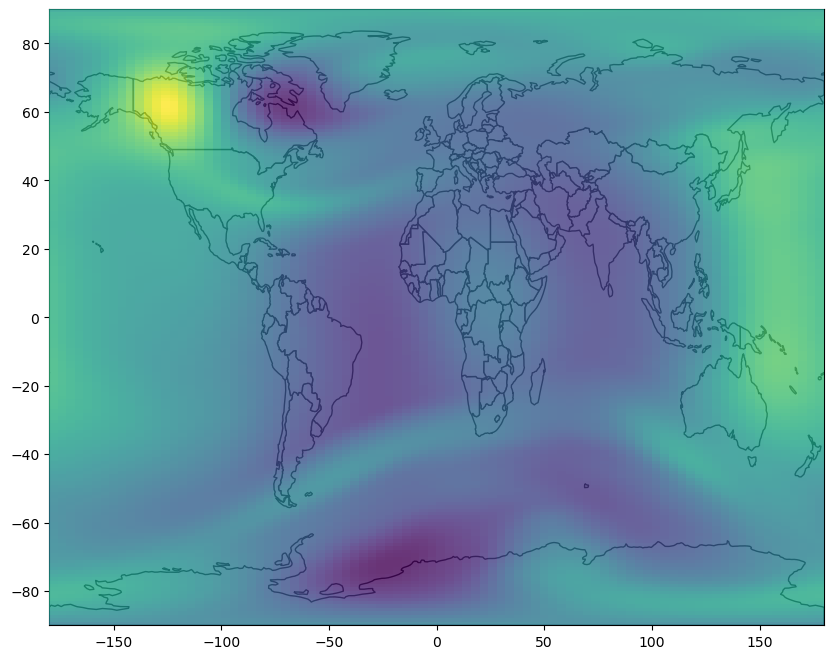

In [241]:
fig,ax = plt.subplots(figsize = (10,8))
world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
#df_loc.plot(ax = ax, x = 'lon', y = 'lat', c = 'Rho', kind = 'scatter', colormap = 'viridis', alpha = 0.3);
plt.imshow(np.flip(np.array(df_loc.Rho)).reshape(len(lons), len(lats)).T, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], zorder = 10, alpha = 0.8)
# ax.colorbar()

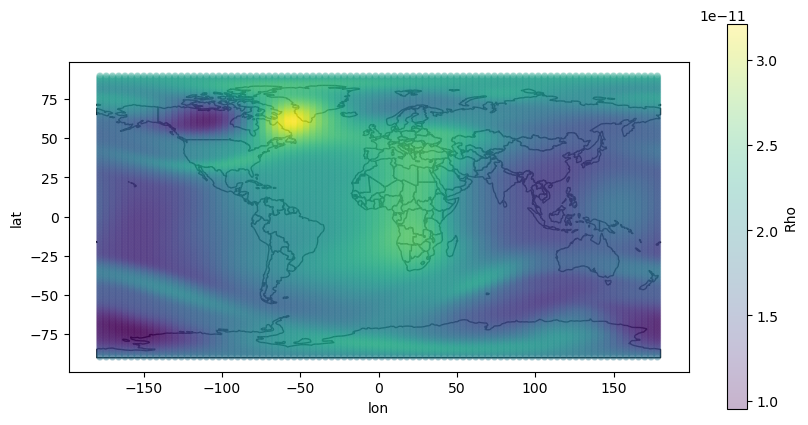

In [213]:
fig,ax = plt.subplots(figsize = (10,5))
world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
df_loc.plot(ax = ax, x = 'lon', y = 'lat', c = 'Rho', kind = 'scatter', colormap = 'viridis', alpha = 0.3);

In [105]:
for key in df.keys():
    print(key, np.max(df[key]), np.min(df[key]))

alt 513110.21404279757 109292.43641210737
lat 89.49999999999999 -89.5
lon 178.00000000000006 -178.0
dtime 2011-05-21 23:35:00 2011-05-21 09:40:00
Rho 1.5791289663470173e-07 1.7368681578819038e-13
[O(!U3!NP)] 5.251727057783363e+17 5792863513224.902
[O!D2!N] 4.791301207094067e+17 170151841.06721616
[N!D2!N] 2.6602169562588017e+18 6704815313.455923
[N(!U4!NS)] 43168126949423.484 8033308076.794004
[NO] 293882938795894.4 2524983.4553562743
[He] 172579196123325.0 33509933526.213047
[N(!U2!ND)] 1155139748673.8997 1.413792604053696
[N(!U2!NP)] 1.0480798512396348e-05 7.404680495440589e-06
[H] 10895834808782.041 39400949186.579346
[CO!D2!N] 735848434232535.9 1352.9523287200004
[O(!U1!ND)] 15385244585.657164 1402.6288073458186
Temperature 2252.7513283693456 164.9851050962087
V!Dn!N(east) 1035.3706983612365 -1207.2815247925278
V!Dn!N(north) 1071.593211716664 -967.4058624751957
V!Dn!N(up) 171.28522580522525 -114.50753140455426
V!Dn!N(up,O(!U3!NP)) 176.4444223435259 -118.94476399422182
V!Dn!N(up,O!D

In [ ]:
#add fits_full to df_sel?
a

In [107]:
df_sel

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature,iTemperature,V!Di!N(east),V!Di!N(north),V!Di!N(up)
0,109292.436412,-89.5,2.0,2011-05-21 09:40:00,9.781481e-08,2.912883e+17,3.066493e+17,1.571676e+18,1.701506e+12,3.335227e+12,...,72385.816235,35628.463728,1.0,3.531023e-15,5.288618e+10,204.811242,225.292367,13.805700,98.212810,-19.625231
1,109292.436412,-88.5,2.0,2011-05-21 09:40:00,9.792469e-08,2.900693e+17,3.078861e+17,1.573305e+18,1.790180e+12,3.762479e+12,...,89957.909054,44434.712534,1.0,3.526795e-15,5.931223e+10,207.468074,228.214882,20.206664,143.845500,-30.161132
2,109292.436412,-87.5,2.0,2011-05-21 09:40:00,9.795592e-08,2.885450e+17,3.088190e+17,1.573776e+18,1.876817e+12,4.227456e+12,...,109365.996485,54157.745026,1.0,3.524138e-15,6.584765e+10,208.239890,229.063879,22.276891,189.338618,-41.549893
3,109292.436412,-86.5,2.0,2011-05-21 09:40:00,9.788380e-08,2.866750e+17,3.092546e+17,1.572806e+18,1.971399e+12,4.759468e+12,...,130589.979406,64809.280124,1.0,3.522230e-15,7.239435e+10,209.577890,230.535679,19.895756,228.176690,-52.352644
4,109292.436412,-85.5,2.0,2011-05-21 09:40:00,9.769737e-08,2.849991e+17,3.092038e+17,1.569840e+18,2.110577e+12,5.435998e+12,...,175084.869706,87011.428125,1.0,3.521063e-15,8.380160e+10,211.990400,233.189440,16.225663,258.832633,-61.452501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721595,109292.436412,85.5,-2.0,2011-05-21 23:35:00,8.234217e-08,8.776046e+16,2.748219e+17,1.393975e+18,9.929651e+11,7.024232e+12,...,26679.481832,17938.409611,1.0,1.635794e-02,1.015688e+11,232.685418,255.953960,-533.080428,-157.057057,7.622317
2721596,109292.436412,86.5,-2.0,2011-05-21 23:35:00,8.241559e-08,8.662799e+16,2.750060e+17,1.395982e+18,9.721741e+11,6.691576e+12,...,35838.866858,23644.215102,1.0,1.967982e-02,1.095559e+11,232.256647,255.482311,-475.671043,-92.963167,10.310497
2721597,109292.436412,87.5,-2.0,2011-05-21 23:35:00,8.250548e-08,8.497552e+16,2.753595e+17,1.398438e+18,9.425167e+11,6.337748e+12,...,31096.791864,21424.626151,1.0,2.348863e-02,1.097850e+11,228.820045,251.702049,-397.508093,-57.224760,10.309863
2721598,109292.436412,88.5,-2.0,2011-05-21 23:35:00,8.235562e-08,8.236783e+16,2.750236e+17,1.397112e+18,9.163895e+11,6.048587e+12,...,28195.679392,20423.093455,1.0,2.817649e-02,1.108465e+11,223.428811,245.771692,-284.611433,-30.838379,9.031220


making maps..:   0%|          | 0/24864 [00:00<?, ?it/s]

/home/axb170054/scratch/made_plots/SimStormPaper/maps/no-bg-removed/109/Total Neutral Density/000.png


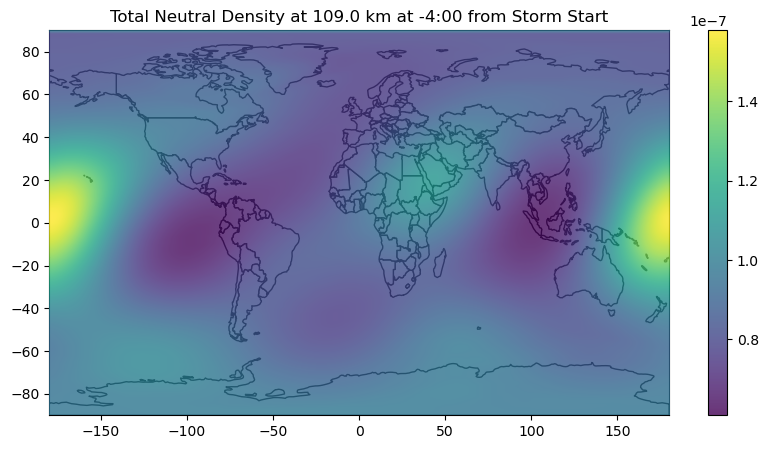

/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass-fit/109/Total Neutral Density/000.png


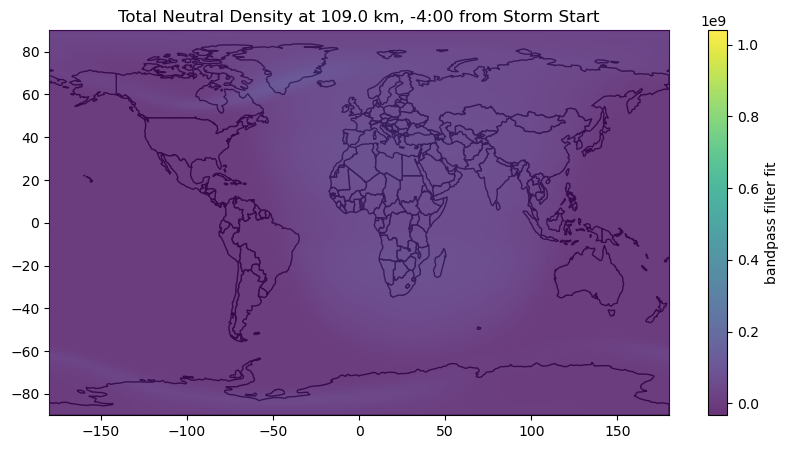

/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass-fit/109/Total Neutral Density/000.png


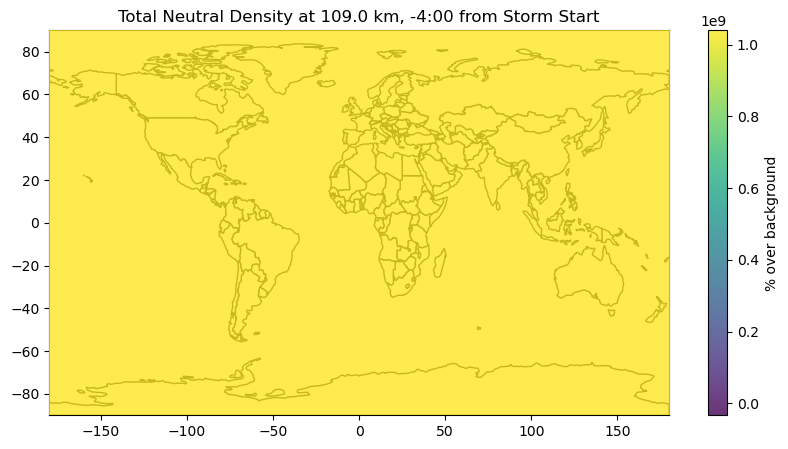

In [102]:
to_save = True

debug = True

pbar = tqdm(desc = 'making maps..', total = len(alts) * len(times) * len(gitm_cols))

for nalt, ialt in enumerate(alts):
    df_sel = df[(df.alt == ialt)].reset_index(drop = True)
    

    for nt, time in enumerate(times):
        df_time = df_sel[df_sel.dtime == time].reset_index(drop = True)
        
        for ncol,icol in enumerate(gitm_cols):
            
            minraw = np.min(df_sel[icol]) #min/max raw
            maxraw = np.max(df_sel[icol])
            
            if both_map_plots or both_map_plots == 'filt':
                # minfit = np.min(fits_full[nalt,:,:,ncol,:]) #min/max of fits
                # maxfit = np.max(fits_full[nalt,:,:,ncol,:])
                # Get fits into df, then this will be easier!
            
            # make arr of zeros, fill it with data. Done once for both_map_plots plot types.
            arr = np.zeros((len(lats), len(lons)))

            for i in range(len(df_time)):
                lon = np.argmin(np.abs(lons - df_time['lon'][i])) #find index of lon
                lat = np.argmin(np.abs(lats - df_time['lat'][i])) #find index of lat
                arr[-lat][lon] = df_time[icol][i] #-needed because matplotlib plots upside-down

                
            if both_map_plots or both_map_plots == 'raw':
                
                
            
                fig,ax = plt.subplots(figsize = (10,5))
                world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
                data = ax.imshow(arr, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], 
                           zorder = 10, alpha = 0.8, vmin = minraw, vmax = maxraw, interpolation='bicubic', interpolation_stage='rgba')

                plt.title(gitm_colnames_friendly[icol] + ' at ' + str(round(float(ialt)/1000,0)) +' km at '
                          + UT_from_Storm_onset(time) +  " from Storm Start")
                fig.colorbar(data)

                if to_save:
                    fname = os.path.join(gitm_map_save_path,'no-bg-removed', str(int(ialt/1000)), gitm_colnames_friendly[icol].replace('(','[').replace(')',']'))

                    if debug:
                        print(fname + '/' + str(nt).rjust(3,'0') + '.png')
                        plt.show()
                        plt.close()
                        if not both_map_plots or both_map_plots == 'raw':
                            break
                    else:
                        if os.path.exists(fname):
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                        else:
                            os.makedirs(fname)
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()

                else:            
                    plt.show()
                    plt.close()

                    if debug:       
                        break
                        
            if both_map_plots or both_map_plots == 'filt':                
                #make plot, plot worls, show arr
                fig,ax = plt.subplots(figsize = (10,5))
                world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
                
                # make data array: fits[ialt][ilat][ilon][col][time_array, len = len(times)]
                fit_here = fits_full[nalt,:,:,ncol,nt]
                
                data = ax.imshow(fit_here, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], 
                           zorder = 10, alpha = 0.8, vmin = minfit, vmax = maxfit, interpolation='bicubic', interpolation_stage='rgba')

                plt.title(gitm_colnames_friendly[icol] + ' at ' + str(round(float(ialt)/1000,0)) +' km, '
                          + UT_from_Storm_onset(time) +  " from Storm Start")
                plt.colorbar(data, label = 'bandpass filter fit')

                if to_save:
                    fname = os.path.join(gitm_map_save_path,'bandpass-fit', str(int(ialt/1000)), gitm_colnames_friendly[icol].replace('(','[').replace(')',']'))

                    if debug:
                        print(fname + '/' + str(nt).rjust(3,'0') + '.png')
                        plt.show()
                        plt.close()
                    else:
                        if os.path.exists(fname):
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                        else:
                            os.makedirs(fname)
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                else:            
                    plt.show()
                    plt.close()
                
                
                
                #now plot out the data - fit:
                fig,ax = plt.subplots(figsize = (10,5))
                world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
                
                # make data array: fits[ialt][ilat][ilon][col][time_array, len = len(times)]
                fit_here = fits_full[nalt,:,:,ncol,nt]
                
                data = ax.imshow((fit_here - arr)/arr, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], 
                           zorder = 10, alpha = 0.8, vmin = minfit, vmax = maxfit, interpolation='bicubic', interpolation_stage='rgba')

                plt.title(gitm_colnames_friendly[icol] + ' at ' + str(round(float(ialt)/1000,0)) +' km, '
                          + UT_from_Storm_onset(time) +  " from Storm Start")
                plt.colorbar(data, label = '% over background')

                if to_save:
                    fname = os.path.join(gitm_map_save_path,'bandpass-fit', str(int(ialt/1000)), gitm_colnames_friendly[icol].replace('(','[').replace(')',']'))

                    if debug:
                        print(fname + '/' + str(nt).rjust(3,'0') + '.png')
                        plt.show()
                        plt.close()
                    else:
                        if os.path.exists(fname):
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                        else:
                            os.makedirs(fname)
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                else:            
                    plt.show()
                    plt.close()
                
                
                
                
                if debug:
                    break
                
                pbar.update(1)
            
        if debug: 
            break
        
    if debug:
        break

In [103]:
fits_full.flatten()[:5]

array([7164244.51055823, 7412466.44147109, 7666567.50160897,
       7908331.95921555, 8168291.81316845])

In [104]:
df_time.head(5)

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature,iTemperature,V!Di!N(east),V!Di!N(north),V!Di!N(up)
0,109292.436412,-89.5,2.0,2011-05-21 09:40:00,9.781481e-08,2.912883e+17,3.066493e+17,1.571676e+18,1.701506e+12,3.335227e+12,...,72385.816235,35628.463728,1.0,3.531023e-15,5.288618e+10,204.811242,225.292367,13.805700,98.212810,-19.625231
1,109292.436412,-88.5,2.0,2011-05-21 09:40:00,9.792469e-08,2.900693e+17,3.078861e+17,1.573305e+18,1.790180e+12,3.762479e+12,...,89957.909054,44434.712534,1.0,3.526795e-15,5.931223e+10,207.468074,228.214882,20.206664,143.845500,-30.161132
2,109292.436412,-87.5,2.0,2011-05-21 09:40:00,9.795592e-08,2.885450e+17,3.088190e+17,1.573776e+18,1.876817e+12,4.227456e+12,...,109365.996485,54157.745026,1.0,3.524138e-15,6.584765e+10,208.239890,229.063879,22.276891,189.338618,-41.549893
3,109292.436412,-86.5,2.0,2011-05-21 09:40:00,9.788380e-08,2.866750e+17,3.092546e+17,1.572806e+18,1.971399e+12,4.759468e+12,...,130589.979406,64809.280124,1.0,3.522230e-15,7.239435e+10,209.577890,230.535679,19.895756,228.176690,-52.352644
4,109292.436412,-85.5,2.0,2011-05-21 09:40:00,9.769737e-08,2.849991e+17,3.092038e+17,1.569840e+18,2.110577e+12,5.435998e+12,...,175084.869706,87011.428125,1.0,3.521063e-15,8.380160e+10,211.990400,233.189440,16.225663,258.832633,-61.452501


In [52]:
fits_full.shape

(180, 90, 37, 168)

In [53]:
fits_full[0][0][0]

array([ 7164244.51055823,  7412466.44147109,  7666567.50160897,
        7908331.95921555,  8168291.81316845,  8408585.89507967,
        8666295.19841437,  8921870.54522678,  9166868.0818339 ,
        9441783.19311118,  9680690.3308648 ,  9952069.41585834,
       10202626.02224262, 10462921.46026424, 10729592.67163019,
       11000247.32473342, 11259988.40052598, 11529063.34285094,
       11726917.36238896, 11946571.96406418, 12034464.55008877,
       12202822.6969599 , 12196245.06335586, 12357815.00877762,
       12311429.80757086, 12488080.89654642, 12434375.90813438,
       12614287.06952911, 12561302.21627561, 12725787.10188521,
       12680864.47359158, 12817232.12727308, 12788659.61740105,
       12887899.96660026, 12883951.8179617 , 12928383.39254862,
       12941521.44207921, 12928815.39651292, 12927992.13440285,
       12949633.73105435, 12914874.61233731, 12998775.41804808,
       12828487.0105086 , 12339637.69524474, 11890088.67378805,
       10097058.09067301,  9861997.72827

In [439]:
test

,A,B,C
0,1,2,3
1,4,5,6
2,7,8,9


In [440]:
test.loc[len(test)] = [5,6,7]

In [441]:
test

,A,B,C
0,1,2,3
1,4,5,6
2,7,8,9
3,5,6,7


In [260]:
len(alts), len(times), len(gitm_cols), len(alts) * len(times) * len(gitm_cols)

(4, 168, 37, 24864)

In [337]:
alt

109292.43641210737

In [335]:
dtime_storm_start + datetime.timedelta(hours = 1)

datetime.datetime(2011, 5, 21, 14, 40)

In [ ]:
df_location = df_sel[(df_sel.lat == df_time.lat[i]) & (df_sel.lon == df_time.lon[i])].reset_index(drop = True)
fit = remove_background(df_location[icol])

In [ ]:
pd.to_timedelta

In [384]:
p=0
while p < len(times):
    l = (df['dtime'][p*len(alts)*len(lats)*len(lons)] - dtime_storm_start)/ pd.Timedelta('1 minute')
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    mins = np.abs(l)%60
    # print(hrs, mins, l, t , dtime_storm_start, p)
    print("%s:%s from storm start" %(hrs, str(int(mins)).rjust(2,'0')))
    p+=10

-4:00 from storm start
-3:10 from storm start
-2:20 from storm start
-1:30 from storm start
00:40 from storm start
00:10 from storm start
01:00 from storm start
01:50 from storm start
02:40 from storm start
03:30 from storm start
04:20 from storm start
05:10 from storm start
06:00 from storm start
06:50 from storm start
07:40 from storm start
08:30 from storm start
09:20 from storm start


In [371]:
np.floor(235/60)

3.0

In [373]:
-235%60

5

In [317]:
icol

'Rho'

In [327]:
for i in range(len(df_time)):
    df_location = df_sel[(df_sel.lat == df_time.lat[i]) & (df_sel.lon == df_time.lon[i])].reset_index(drop = True)
    fit = remove_background(df_location[icol])
    
    
    
    break

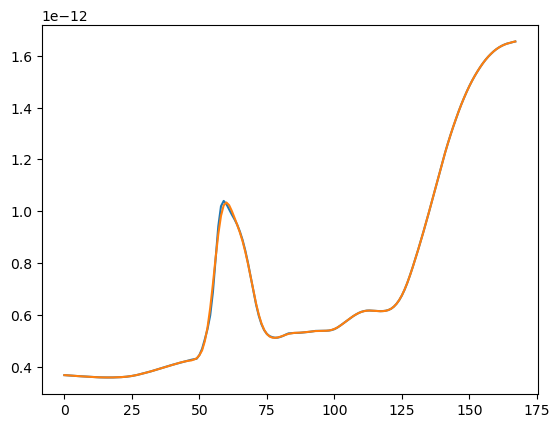

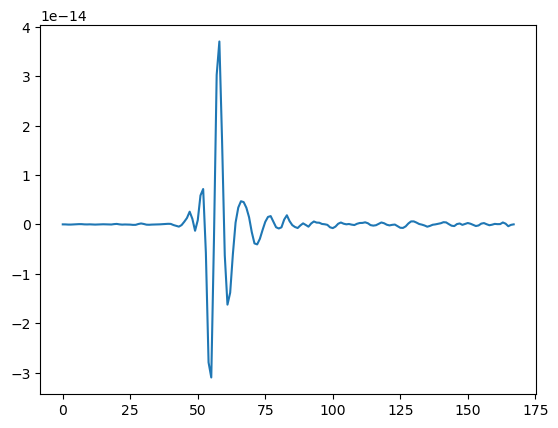

2011-05-21 09:40:00


In [332]:
plt.plot(df_location[icol])
plt.plot(fit)
plt.show()
plt.close()

plt.plot(df_location[icol] - fit)
plt.show()
plt.close()
print(df_time['dtime'][i])

In [334]:
times[storm_start_index]

IndexError: index 452 is out of bounds for axis 0 with size 168

In [284]:

arr.shape, len(lats), len(lons)

((180, 90), 180, 90)

In [316]:
fits.keys(), fits[2].keys(), fits[2][136877.51637131226].keys()

(dict_keys([-90, 2, 90, -178]),
 dict_keys([109292.43641210737, 136877.51637131226, 319673.6422589202, 513110.21404279757]),
 dict_keys(['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']))

In [308]:
arr = np.zeros((len(lats), len(lons)))
for i in range(len(df_time)):
    lon = np.argmin(np.abs(lons - df_time['lon'][i]))
    lat = np.argmin(np.abs(lats - df_time['lat'][i]))
    arr[-lat][lon] = df_time[icol][i]

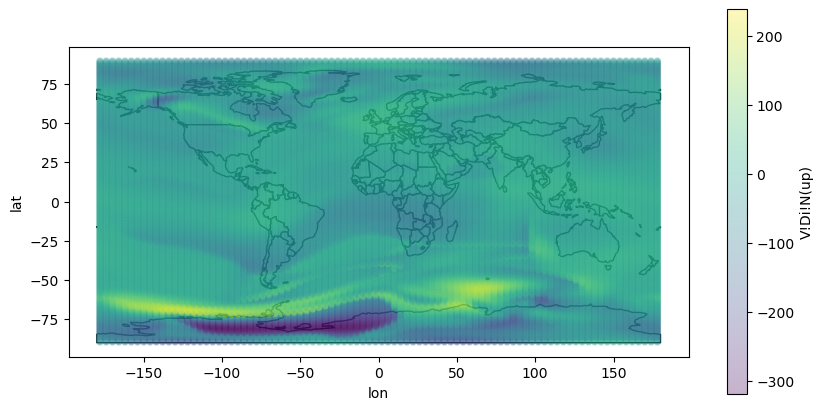

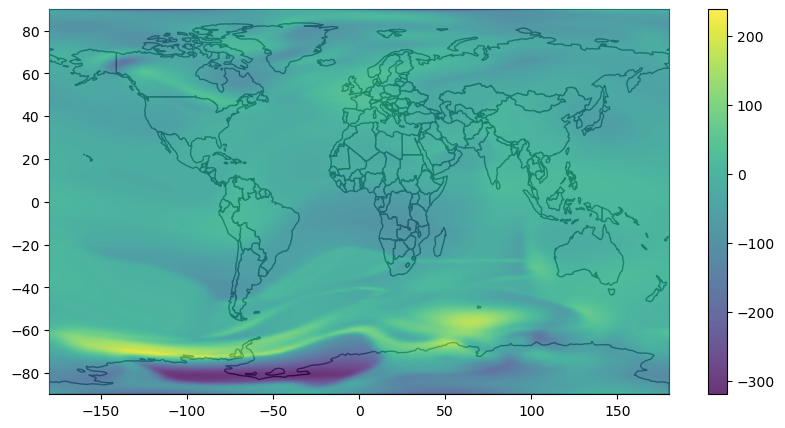

In [310]:
fig,ax = plt.subplots(figsize = (10,5))
world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
df_time.plot(ax = ax, x = 'lon', y = 'lat', c = icol, kind = 'scatter', colormap = 'viridis', alpha = 0.3);
plt.show()
plt.close()

fig,ax = plt.subplots(figsize = (10,5))
world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
#df_loc.plot(ax = ax, x = 'lon', y = 'lat', c = 'Rho', kind = 'scatter', colormap = 'viridis', alpha = 0.3);
plt.imshow(arr, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], zorder = 10, alpha = 0.8, interpolation='bicubic')
plt.colorbar()
plt.show()
plt.close()

In [304]:
df_time

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature,iTemperature,V!Di!N(east),V!Di!N(north),V!Di!N(up)
0,513110.214043,-89.5,2.0,2011-05-21 23:35:00,1.655178e-12,5.569783e+13,2.879517e+10,1.456337e+12,1.472910e+11,3.751509e+08,...,7.654450e+07,3.453691e+05,1.0,9.609940e-08,5.698825e+10,1564.712527,1603.790783,-471.813043,13.626108,-82.053550
1,513110.214043,-88.5,2.0,2011-05-21 23:35:00,1.626650e-12,5.465671e+13,2.741929e+10,1.376955e+12,1.364317e+11,3.988693e+08,...,1.530924e+08,6.792370e+05,1.0,1.261259e-02,5.881721e+10,1634.738701,1599.878539,-503.274342,57.389768,-95.863335
2,513110.214043,-87.5,2.0,2011-05-21 23:35:00,1.606077e-12,5.386590e+13,2.740251e+10,1.363675e+12,1.353755e+11,4.095593e+08,...,2.468511e+08,1.096322e+06,1.0,1.565477e+01,6.776508e+10,1709.640523,1580.949644,-522.024686,115.476007,-85.223698
3,513110.214043,-86.5,2.0,2011-05-21 23:35:00,1.591589e-12,5.334786e+13,2.767385e+10,1.362808e+12,1.351385e+11,4.071757e+08,...,3.157959e+08,1.455031e+06,1.0,2.088300e+02,8.232513e+10,1761.750575,1556.170572,-521.032567,185.107782,-76.821161
4,513110.214043,-85.5,2.0,2011-05-21 23:35:00,1.585447e-12,5.314860e+13,2.845118e+10,1.378308e+12,1.373162e+11,4.046336e+08,...,3.754073e+08,1.786859e+06,1.0,1.439304e+03,9.624354e+10,1800.710125,1537.932930,-501.015103,270.069602,-64.764022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,513110.214043,85.5,-2.0,2011-05-21 23:35:00,9.463642e-13,2.259466e+13,3.217037e+11,6.750389e+12,3.027802e+11,1.066359e+10,...,1.598369e+09,1.755849e+07,1.0,1.475879e+06,1.000119e+11,2941.528836,2091.506190,-586.700825,-443.455198,-25.268824
16196,513110.214043,86.5,-2.0,2011-05-21 23:35:00,9.780155e-13,2.346138e+13,3.304942e+11,6.912764e+12,3.154406e+11,1.123287e+10,...,1.614810e+09,1.817036e+07,1.0,1.464123e+06,1.010987e+11,2948.784720,2131.984397,-552.767409,-345.378338,0.923166
16197,513110.214043,87.5,-2.0,2011-05-21 23:35:00,1.001021e-12,2.419722e+13,3.348940e+11,6.971572e+12,3.304064e+11,1.183729e+10,...,1.635891e+09,1.863221e+07,1.0,1.493224e+06,1.009208e+11,2954.958234,2162.889821,-476.670648,-248.921811,14.462110
16198,513110.214043,88.5,-2.0,2011-05-21 23:35:00,1.005548e-12,2.451618e+13,3.323257e+11,6.881966e+12,3.413096e+11,1.228652e+10,...,1.654074e+09,1.879029e+07,1.0,1.544104e+06,9.968743e+10,2959.405348,2210.666078,-360.662760,-151.804014,12.140229
